<a href="https://colab.research.google.com/github/Evanosas/wasteclassification/blob/main/CAID_WASTE_CLASSIFICATION_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Waste Classification Project**

Welcome to the Waste Classification Project, where we aim to automatically classify waste images into 9 different categories using modern deep learning techniques.

**📌 Project Overview**

In many real-world scenarios, collecting a large, diverse, and well-labeled dataset can be challenging. Training a deep neural network from scratch often requires tens or hundreds of thousands of images, which is not practical for a small project.

So, how do we achieve high accuracy with limited data?

**🚀 Transfer Learning**

We make use of Transfer Learning, a powerful technique where we reuse knowledge from a pretrained model. Instead of training a deep network from zero, we:

Take an existing model already trained on millions of images (e.g., ImageNet).

Adapt (fine-tune) specific layers to our smaller dataset.

Achieve strong performance with less data, less training time, and better generalization.

This approach lets us focus on the waste-classification task without needing an extremely large dataset.

**📂 Dataset**

For this project, we’ll use a small yet effective dataset available on GitHub:

🔗 Waste Images Dataset (5,000 images)
https://github.com/cardstdani/WasteClassificationNeuralNetwork/tree/main/WasteImagesDataset

It contains 9 waste categories, providing enough variety for fine-tuning a pretrained model.

🧠 **Base Model**

Our base model is MobileNetV3, a lightweight and efficient convolutional neural network designed for mobile and resource-constrained environments. It offers:

Fast inference

Low computational cost

Strong performance on image classification tasks

This makes it a great choice for building a waste-sorting system that could eventually run on edge devices or mobile applications.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

##**Data Gathering and Preprocessing**

In [ ]:
!git clone https://github.com/cardstdani/WasteClassificationNeuralNetwork.git

Cloning into 'WasteClassificationNeuralNetwork'...
remote: Enumerating objects: 5092, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5092 (delta 10), reused 23 (delta 9), pack-reused 5068 (from 1)
Receiving objects: 100% (5092/5092), 223.89 MiB | 39.01 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (5082/5082), done.


In [ ]:
#LOAD DATA
DIR = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128,  image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128,  image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


##**Model Training**

In [ ]:
import tensorflow as tf
import math

# Load MobileNetV3
baseModel = tf.keras.applications.MobileNetV3Large(
    input_shape=(256, 256, 3),
    include_top=False,
    weights="imagenet"
)

# Unfreeze last 30 layers
for layer in baseModel.layers[:-30]:
    layer.trainable = False

# Build classifier head
last = baseModel.output
x = tf.keras.layers.GlobalAveragePooling2D()(last)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(
        256,
        activation="elu",
        kernel_initializer="he_normal"
    )(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(numClasses, activation="softmax")(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=output)

# Use correct loss (softmax → from_logits=False)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Learning rate schedule (simple)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.5   # half LR after 10 epochs

lrCallback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Train
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=40,
    callbacks=[lrCallback]
)


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.3330 - loss: 2.6314 - val_accuracy: 0.7613 - val_loss: 0.6761 - learning_rate: 2.5000e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 295ms/step - accuracy: 0.7704 - loss: 0.7195 - val_accuracy: 0.8501 - val_loss: 0.4264 - learning_rate: 2.5000e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.8920 - loss: 0.3381 - val_accuracy: 0.8659 - val_loss: 0.3503 - learning_rate: 2.5000e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.9073 - loss: 0.2496 - val_accuracy: 0.8777 - val_loss: 0.3294 - learning_rate: 2.5000e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.9385 - loss: 0.1746 - val_accuracy: 0.9014 - val_loss: 0.2976 - learning_rate: 2.5000e-04
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.9613 - loss: 0.1148 - val_accuracy: 0.9132 - val_loss: 0.2809 - learning_rate: 2.5000e-04
Epoch 7/40


In [ ]:
model.save("/content/model.h5")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 128, 128,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 128, 128,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 128, 128,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 128, 128,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 128, 128,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 129, 129,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 64, 64,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 64, 64,    │        256 │ expanded_conv_1_

 Total params: 6,938,461 (26.47 MB)

 Trainable params: 1,844,969 (7.04 MB)

 Non-trainable params: 1,403,552 (5.35 MB)

 Optimizer params: 3,689,940 (14.08 MB)

##**Model Evaluation**

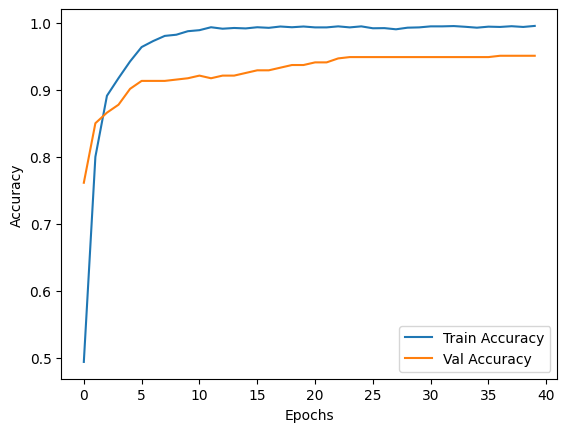

In [ ]:
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Train Accuracy")
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Val Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
import requests

img_data = requests.get("https://www.wastemanaged.co.uk/wp-content/uploads/2024/02/WM-Images-43.jpg").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

NameError: name 'tf' is not defined